Выберите ряд и постройте его модель ARIMA/GARCH.

Не обязательное дз. Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")

In [3]:
series = robberies_in_boston["Count"]

In [4]:
len(series)

118

In [5]:
from statsmodels.tsa.arima_model import ARIMA

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

aic: 1186.95060 | order: (4, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                -8.712824e+00
p-value                        3.553033e-14
#Lags Used                     1.000000e+00
Number of Observations Used    1.150000e+02
Critical Value (1%)           -3.488535e+00
Critical Value (5%)           -2.887020e+00
Critical Value (10%)          -2.580360e+00
dtype: float64


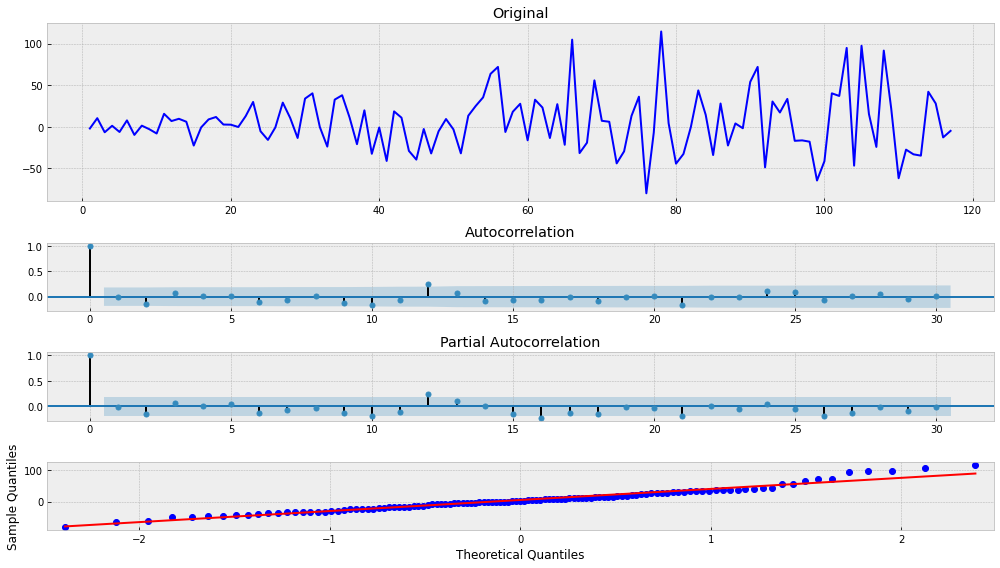

In [8]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

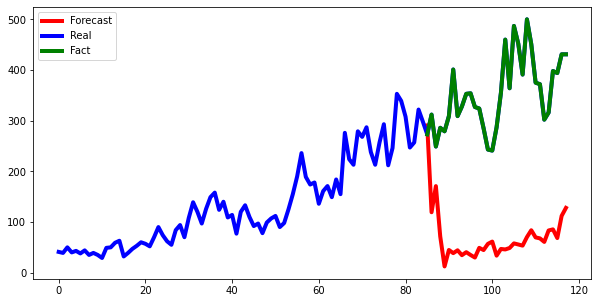

[array([290.58586278]), array([119.30090158]), array([170.84858637]), array([71.59212767]), array([12.29963866]), array([44.83986862]), array([38.57983354]), array([44.14908776]), array([34.56222639]), array([40.45027531]), array([34.91590069]), array([29.88778514]), array([48.99635365]), array([44.6850976]), array([56.87506268]), array([61.36440733]), array([33.64465685]), array([46.81424164]), array([45.85618788]), array([48.70519345]), array([57.80505016]), array([55.66615526]), array([53.38528068]), array([70.24410715]), array([83.77290089]), array([69.60642207]), array([67.70547641]), array([60.69489295]), array([83.31356806]), array([85.48944118]), array([68.32256765]), array([112.04283369]), array([127.90072456])]


In [16]:
    history = [x for x in series[:85]]
    pred = []
    for i in range(len(series[85:])):
        model = ARIMA(history, order=(4,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yi = output[0]
        pred.append(yi)
        obs = series[i]
        history.append(obs)
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(85,118)), pred, color='red', linewidth='4', label='Forecast')
    plt.plot(list(range(118)), series, color='blue', linewidth='4', label='Real')
    plt.plot(list(range(85,118)), series[85:], color='green', linewidth='4', label='Fact')
    plt.legend()
    plt.show()
    print(pred)

График поддержал тренд, но очень сместился.

In [18]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = prepareData(robberies_in_boston, lag_start=1, lag_end=20, test_size=0.3)

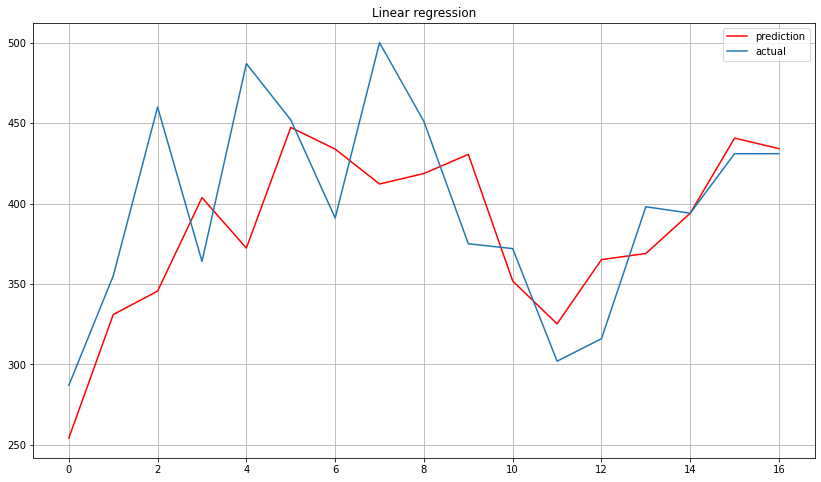

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);